In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch import nn, optim

In [2]:
#configurations
device = "cuda" if torch.cuda.is_available() else "cpu"
batch_size = 128
noise_dimensions = 64
learning_rate = 0.0002
beta_1 = 0.5
beta_2 = 0.99

In [3]:
from torchvision import datasets, transforms

train_augs = transforms.Compose([
    transforms.RandomRotation((-20, 20)),
    transforms.ToTensor(),
    
])

In [4]:
trainset = datasets.MNIST('./data', download=True, transform = train_augs)

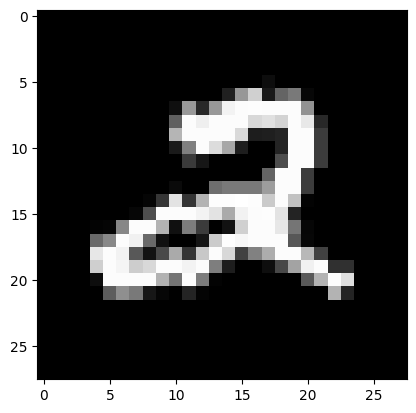

In [5]:
image, label = trainset[5]
plt.imshow(image.squeeze(), cmap='gray')

In [6]:
from torch.utils.data import DataLoader
from torchvision.utils import make_grid

In [7]:
trainloader = DataLoader(dataset=trainset, batch_size=batch_size, shuffle=True)

In [8]:
data_iter = iter(trainloader)
images, _ = next(data_iter)
images.shape

torch.Size([128, 1, 28, 28])

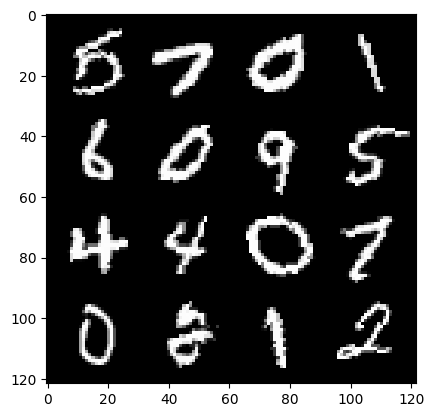

In [9]:
def showTensorImages(tensor_img, num_images=16, size=(1, 28, 28)):
    unflat_img = tensor_img.detach().cpu()
    img_grid = make_grid(unflat_img[:num_images], nrow=4)
    plt.imshow(img_grid.permute(1, 2, 0).squeeze())
    plt.show()

showTensorImages(images, num_images=16)

In [10]:
from torchsummary import summary

In [11]:
def get_descriminator_block(in_channels, out_channels, kernel_size, stride):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size, stride),
        nn.BatchNorm2d(out_channels),
        nn.LeakyReLU(0.2)
    )

In [12]:
class Descriminator(nn.Module):
    def __init__(self):
        super(Descriminator, self).__init__()

        self.block1 = get_descriminator_block(1, 16, (3, 3), 2)
        self.block2 = get_descriminator_block(16, 32, (5, 5), 2)
        self.block3 = get_descriminator_block(32, 64, (5, 5), 2)
        self.flatten = nn.Flatten()
        self.linear = nn.Linear(in_features=64, out_features=1)

    def forward(self, x):
        x1 = self.block1(x)
        x2 = self.block2(x1)
        x3 = self.block3(x2)
        x4 = self.flatten(x3)
        x5 = self.linear(x4)
        return x5

In [13]:
descriminator = Descriminator()
descriminator.to(device)

summary(descriminator, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 13, 13]             160
       BatchNorm2d-2           [-1, 16, 13, 13]              32
         LeakyReLU-3           [-1, 16, 13, 13]               0
            Conv2d-4             [-1, 32, 5, 5]          12,832
       BatchNorm2d-5             [-1, 32, 5, 5]              64
         LeakyReLU-6             [-1, 32, 5, 5]               0
            Conv2d-7             [-1, 64, 1, 1]          51,264
       BatchNorm2d-8             [-1, 64, 1, 1]             128
         LeakyReLU-9             [-1, 64, 1, 1]               0
          Flatten-10                   [-1, 64]               0
           Linear-11                    [-1, 1]              65
Total params: 64,545
Trainable params: 64,545
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/ba

In [14]:
def get_generator_block(in_channels, out_channels, kernel_size, stride):
    return nn.Sequential(
        nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride),
        nn.BatchNorm2d(out_channels),
        nn.ReLU()
    )

def get_last_generator_block(in_channels, out_channels, kernel_size, stride):
    return nn.Sequential(
        nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride),
        nn.Tanh()
    )

In [15]:
class Generator(nn.Module):
    def __init__(self, noise_dim):
        super(Generator, self).__init__()
        self.noise_dim = noise_dim
        self.block_1 = get_generator_block(noise_dimensions, 256, (3, 3), 2)
        self.block_2 = get_generator_block(256, 128, (4, 4), 1)
        self.block_3 = get_generator_block(128, 64, (3, 3), 2)
        self.block_4 = get_last_generator_block(64, 1, (4, 4), 2)

    def forward(self, noise_vector):
        x = noise_vector.view(-1, self.noise_dim, 1, 1)

        x1 = self.block_1(x)
        x2 = self.block_2(x1)
        x3 = self.block_3(x2)
        x4 = self.block_4(x3)

        return x4

In [16]:
generator = Generator(noise_dimensions)
generator.to(device)

summary(generator, input_size=(1, noise_dimensions))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1            [-1, 256, 3, 3]         147,712
       BatchNorm2d-2            [-1, 256, 3, 3]             512
              ReLU-3            [-1, 256, 3, 3]               0
   ConvTranspose2d-4            [-1, 128, 6, 6]         524,416
       BatchNorm2d-5            [-1, 128, 6, 6]             256
              ReLU-6            [-1, 128, 6, 6]               0
   ConvTranspose2d-7           [-1, 64, 13, 13]          73,792
       BatchNorm2d-8           [-1, 64, 13, 13]             128
              ReLU-9           [-1, 64, 13, 13]               0
  ConvTranspose2d-10            [-1, 1, 28, 28]           1,025
             Tanh-11            [-1, 1, 28, 28]               0
Total params: 747,841
Trainable params: 747,841
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/

In [17]:
def real_loss(discriminator_predictions):
    criterion = nn.BCEWithLogitsLoss()
    ground_truth = torch.ones_like(discriminator_predictions)
    loss = criterion(discriminator_predictions, ground_truth)

    return loss

def fake_loss(discriminator_predictions):
    criterion = nn.BCEWithLogitsLoss()
    ground_truth = torch.zeros_like(discriminator_predictions)
    loss = criterion(discriminator_predictions, ground_truth)

    return loss

In [18]:
descrimator_optimizer = optim.Adam(descriminator.parameters(), lr=learning_rate, betas=(beta_1, beta_2))
generator_optimizer = optim.Adam(generator.parameters(), lr=learning_rate, betas=(beta_1, beta_2))

100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [01:22<00:00,  5.69it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


Epochs: 0, D loss: 0.6427563428878784, G loss: 0.7580307722091675


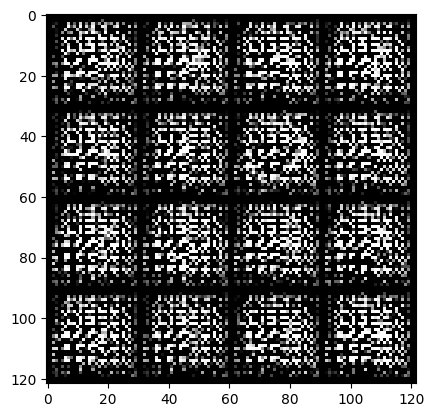

100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [01:22<00:00,  5.69it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.99999297].


Epochs: 1, D loss: 0.5958483815193176, G loss: 0.8287680149078369


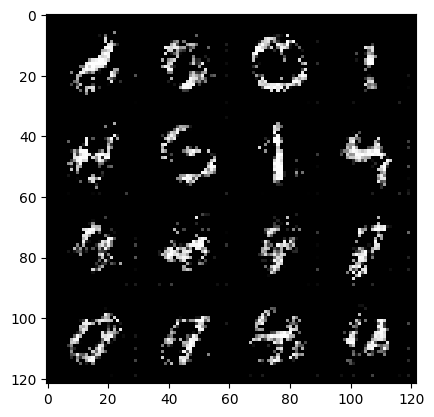

100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [01:22<00:00,  5.69it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.99999946].


Epochs: 2, D loss: 0.6356315612792969, G loss: 0.7847148180007935


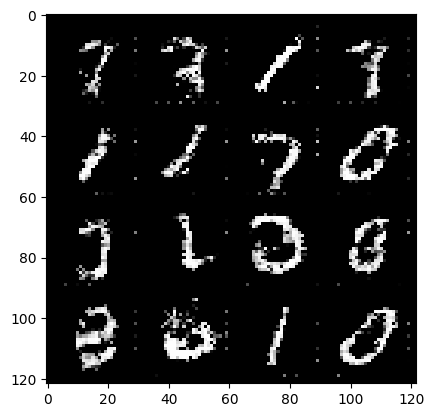

100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [01:22<00:00,  5.70it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.99999875].


Epochs: 3, D loss: 0.6482580304145813, G loss: 0.7724879384040833


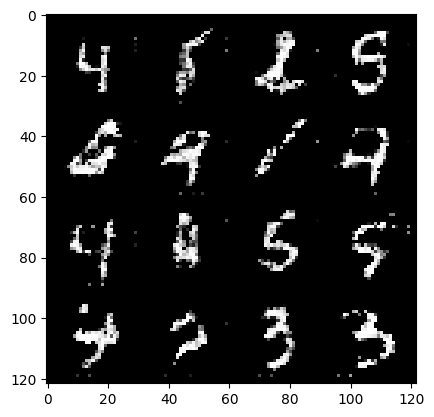

100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [01:22<00:00,  5.69it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.99998677].


Epochs: 4, D loss: 0.6547595858573914, G loss: 0.7661179900169373


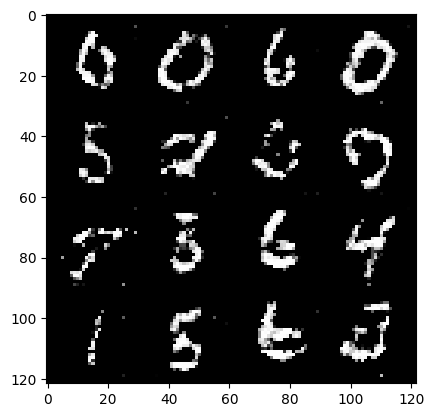

100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [01:22<00:00,  5.70it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.99999285].


Epochs: 5, D loss: 0.6576268076896667, G loss: 0.7646780610084534


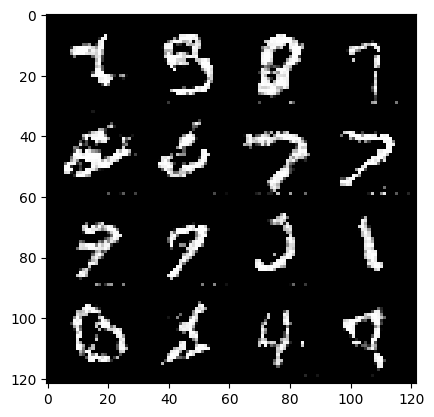

100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [01:22<00:00,  5.66it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.99999654].


Epochs: 6, D loss: 0.6614586114883423, G loss: 0.76041179895401


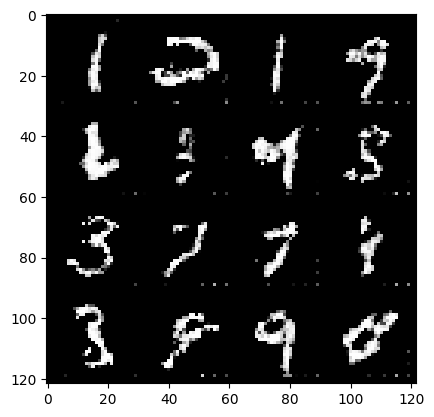

100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [01:23<00:00,  5.63it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.99999756].


Epochs: 7, D loss: 0.6637135744094849, G loss: 0.7576492428779602


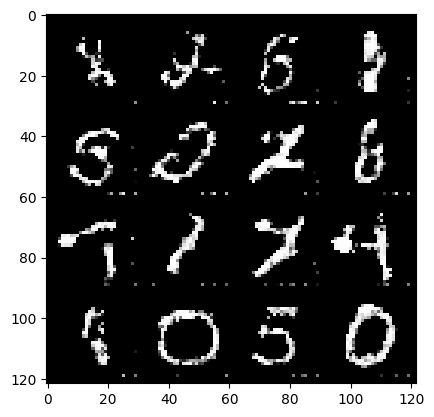

100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [01:23<00:00,  5.63it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.999999].


Epochs: 8, D loss: 0.6670570373535156, G loss: 0.7543997764587402


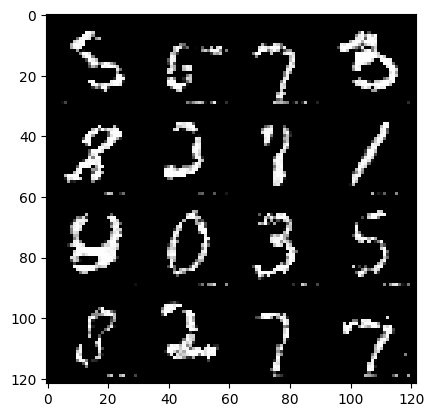

100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [01:23<00:00,  5.63it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.9999768].


Epochs: 9, D loss: 0.6681898236274719, G loss: 0.7539492249488831


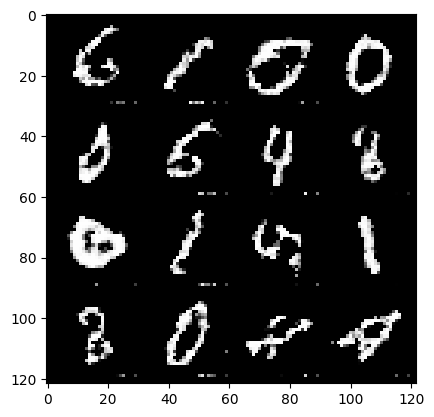

100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [01:23<00:00,  5.63it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.99999964].


Epochs: 10, D loss: 0.6693929433822632, G loss: 0.7522329688072205


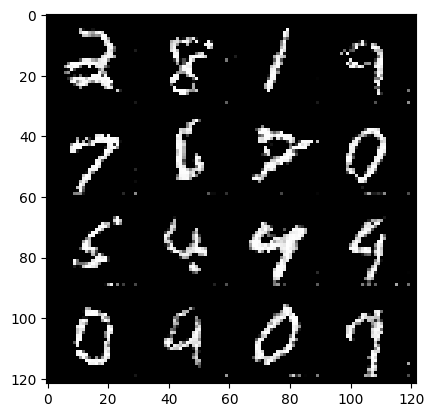

100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [01:22<00:00,  5.68it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.99999976].


Epochs: 11, D loss: 0.6701970100402832, G loss: 0.7500078678131104


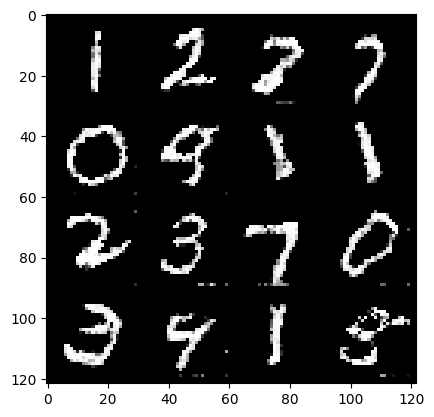

100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [01:23<00:00,  5.63it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.9999944].


Epochs: 12, D loss: 0.6708194613456726, G loss: 0.7503711581230164


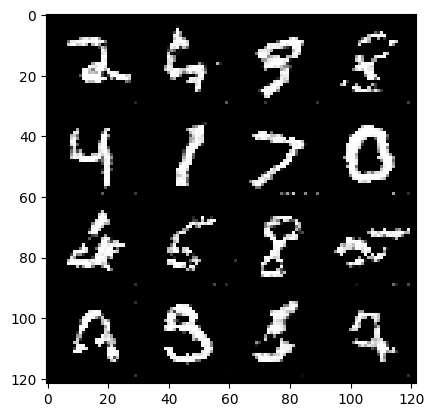

100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [01:23<00:00,  5.64it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.9999804].


Epochs: 13, D loss: 0.6697549819946289, G loss: 0.7503366470336914


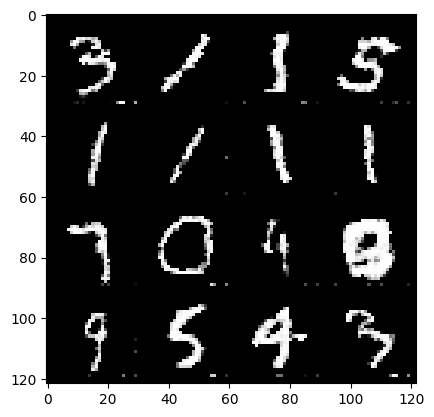

100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [01:23<00:00,  5.63it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.9999967].


Epochs: 14, D loss: 0.6697796583175659, G loss: 0.7497313618659973


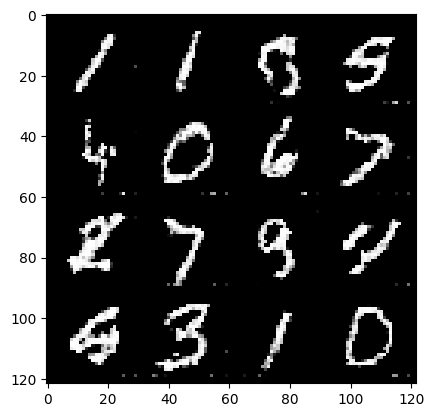

100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [01:22<00:00,  5.69it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.9999967].


Epochs: 15, D loss: 0.6700789928436279, G loss: 0.749941349029541


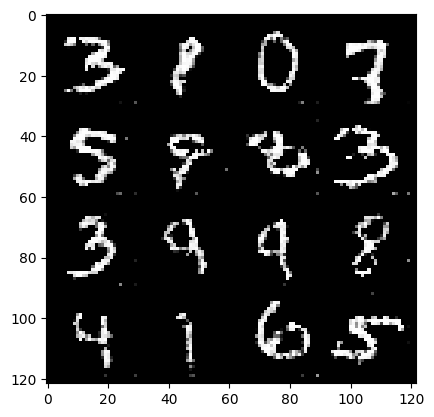

100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [01:23<00:00,  5.63it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.9999662].


Epochs: 16, D loss: 0.6709942817687988, G loss: 0.7491667866706848


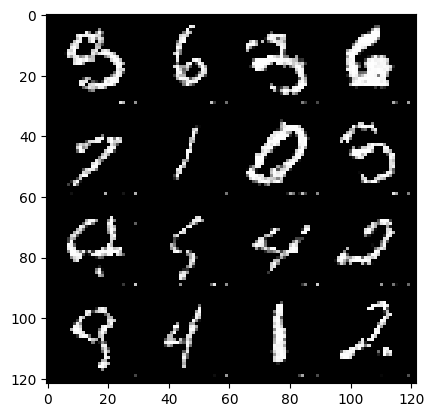

100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [01:23<00:00,  5.63it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.9999665].


Epochs: 17, D loss: 0.6713383197784424, G loss: 0.7494503855705261


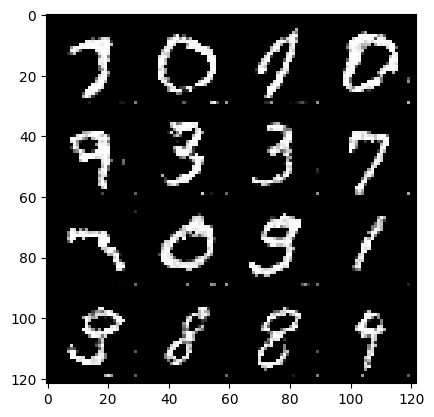

100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [01:22<00:00,  5.68it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.99992794].


Epochs: 18, D loss: 0.670759379863739, G loss: 0.7496082186698914


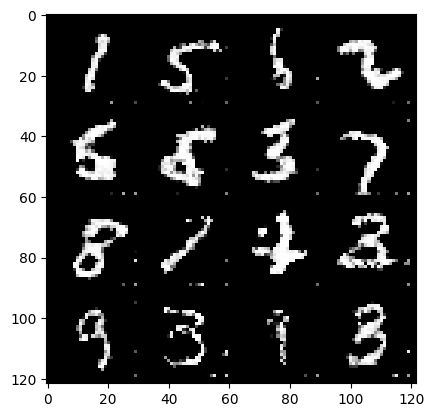

100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [01:23<00:00,  5.63it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.9999718].


Epochs: 19, D loss: 0.6721592545509338, G loss: 0.7479808330535889


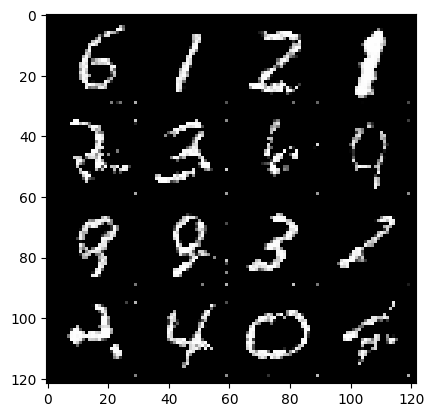

100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [01:23<00:00,  5.63it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.99995834].


Epochs: 20, D loss: 0.6711645722389221, G loss: 0.7512176036834717


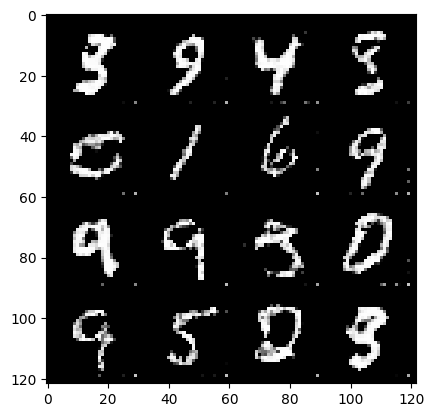

100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [01:22<00:00,  5.69it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.99999493].


Epochs: 21, D loss: 0.6702646613121033, G loss: 0.7499999403953552


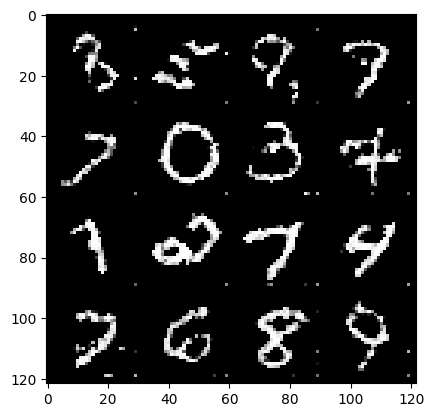

100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [01:23<00:00,  5.63it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.9999881].


Epochs: 22, D loss: 0.6709281206130981, G loss: 0.7510688304901123


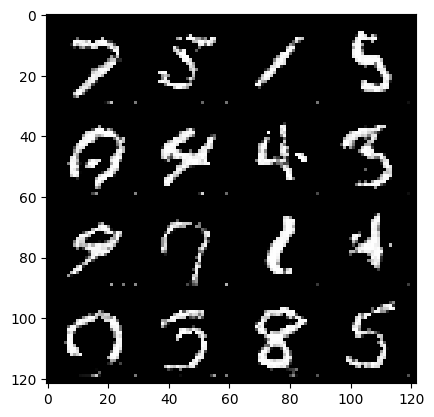

100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [01:23<00:00,  5.63it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.9999786].


Epochs: 23, D loss: 0.6709989905357361, G loss: 0.7517889738082886


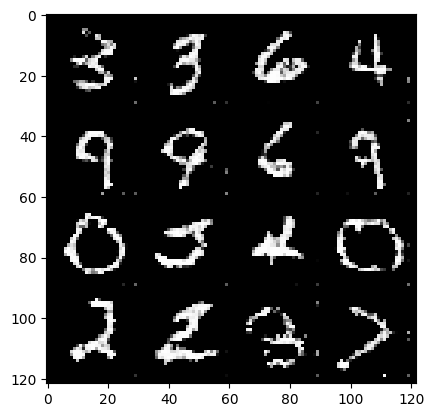

100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [01:22<00:00,  5.68it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.9999318].


Epochs: 24, D loss: 0.670235276222229, G loss: 0.7535005807876587


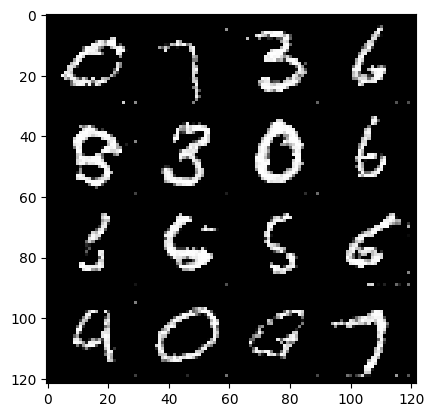

In [19]:
from tqdm import tqdm

epochs = 25
for i in range(epochs):
    total_d_loss = 0.0
    total_g_loss = 0.0

    for real_img, _ in tqdm(trainloader):
        real_img = real_img.to(device)
        noise = torch.randn(batch_size, noise_dimensions, device=device)

        descrimator_optimizer.zero_grad()
        
        fake_img = generator(noise)
        descriminator_predictions = descriminator(fake_img)
        descriminator_fake_loss = fake_loss(descriminator_predictions)

        descriminator_predictions = descriminator(real_img)
        descriminator_real_loss = real_loss(descriminator_predictions)

        d_loss = (descriminator_fake_loss + descriminator_real_loss) / 2
        total_d_loss += d_loss
        d_loss.backward()
        descrimator_optimizer.step()

        generator_optimizer.zero_grad()
        noise = torch.randn(batch_size, noise_dimensions, device=device)

        fake_img = generator(noise)
        descriminator_predictions = descriminator(fake_img)
        g_loss = real_loss(descriminator_predictions)
        total_g_loss += g_loss

        g_loss.backward()
        generator_optimizer.step()
        
    avg_d_loss = total_d_loss / len(trainloader)
    avg_g_loss = total_g_loss / len(trainloader)
    print(f'Epochs: {i}, D loss: {avg_d_loss}, G loss: {avg_g_loss}')
    showTensorImages(fake_img)

In [21]:
torch.save(generator.state_dict(), "./dcgan_generator.pt")
torch.save(descriminator.state_dict(), "./dcgan_descriminator.pt")